In [1]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_array, check_is_fitted

import numpy as np
import matplotlib.pyplot as plt
import os
import copy
import inspect

from scipy import optimize
from sklearn import decomposition, cluster, model_selection, metrics
import sklearn

In [2]:
def normalize(X):
    """ 
    Z normalization
    Make everything positive (NNLS does not work otherwise)
    """
    X = (X - X.mean(axis=0)) / X.std(axis=0)
    return X - X.min(axis=0)

In [3]:
kwargs = {'n_clusters': 3,
          'n_components': 20}

X = np.load("../data/HSI/Liver_map_150z25_60s_1TCPOBOP.npy", 'r')
Y = np.load("../data/HSI/Liver_map_150z25_60s_2TCPOBOP.npy", 'r')
Z = np.load("../data/HSI/Liver_map_150z25_60s_3OBOB.npy", 'r')

shape_X = X.shape 
shape_Y = Y.shape 
shape_Z = Z.shape 

X = copy.copy(X.reshape(-1, X.shape[-1]))
Y = copy.copy(Y.reshape(-1, Y.shape[-1]))
Z = copy.copy(Z.reshape(-1, Z.shape[-1]))

X = normalize(X)
Y = normalize(Y)
Z = normalize(Z)

In [4]:
class ReferenceVectorClassifierPCA(BaseEstimator):
    def __init__(self, **kwargs):
        self.kwargs = {}
        self.pca_kwargs = {}
        self.k_means_kwargs = {}        
        self.set_params(**kwargs)
        
    def fit(self, X, **kwargs):
        self.set_params(**kwargs)
        ###################### PCA ################################
        pca = decomposition.PCA(**self.pca_kwargs)
        pca.fit(X)
        X_pca = pca.transform(X)

        ###################### clustering ################################
        self.clusters = cluster.KMeans(**self.k_means_kwargs).fit(X_pca)
        self.clusters = self.clusters.labels_
        
        one_hot = np.zeros((X.shape[0], self.kwargs['n_clusters']), dtype=bool)
        one_hot[range(X.shape[0]), self.clusters] = 1

        ###################### reference spectra ################################
        self.reference_spectra_ = np.array([X[one_hot[:,i],:].mean(axis=0) for i in range(self.kwargs['n_clusters'])])
  
        # Return the classifier
        return self

    def predict(self, X):
        """
        predict transforms the data into the reference space. Min weight should be 0 or higher then 'min_weight'
        The error is the NMSE, where the MSE is normalised by the signal strength. 
        error.shape = X.shape[0], so for each data point the error is calculated.
        """
        # Check is fit had been called
        check_is_fitted(self)

        # Input validation
        X = check_array(X)
        
        ###################### RCA ################################
        old_mask = np.zeros((X.shape[0], self.kwargs['n_clusters']), dtype=bool)
        mask = np.ones((X.shape[0], self.kwargs['n_clusters']), dtype=bool)
        while np.abs(old_mask ^ mask).sum():
            RCA_vector, error = list(zip(*[optimize.nnls(self.reference_spectra_.T * mask[i], X[i,:]) for i in range(X.shape[0])]))
            RCA_vector = np.array(RCA_vector)
            old_mask, mask = mask, (RCA_vector.T / RCA_vector.sum(axis=1)).T >= self.kwargs['min_weight']            
        
        self.error = np.array(error) / X.mean(axis=1)
        return RCA_vector  

    def get_params(self, deep=False):
        return self.kwargs
    
    def set_params(self, **kwargs):
        self.kwargs.update(kwargs)
        self.pca_kwargs.update({k:v  for k,v in kwargs.items() if k in list(inspect.signature(decomposition.PCA).parameters.keys())})
        self.k_means_kwargs.update({k:v  for k,v in kwargs.items() if k in list(inspect.signature(cluster.KMeans).parameters.keys())})     
        return self
        
    def score(self, X):
        """
        Score is 1 / error to transform a loss fucntion into a score function.
        """
        self.predict(X)
        return 1 / self.error.mean()

In [5]:
################################# cross_val_score #######################
kwargs = {'n_clusters': 3,
          'n_components': 20,
          'min_weight': 0}

rvc = ReferenceVectorClassifierPCA(**kwargs)
print("cross_val_score: ", model_selection.cross_val_score(rvc, X, None, scoring=None))


cross_val_score:  [0.62711485 0.50432647 0.38678899 0.1707288  0.43884619]


fit score:  0.3831459470590349


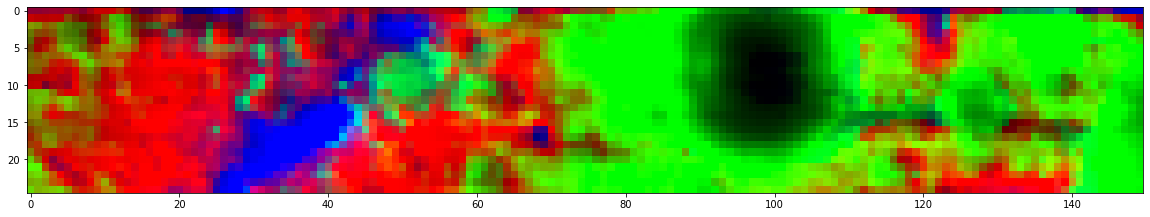

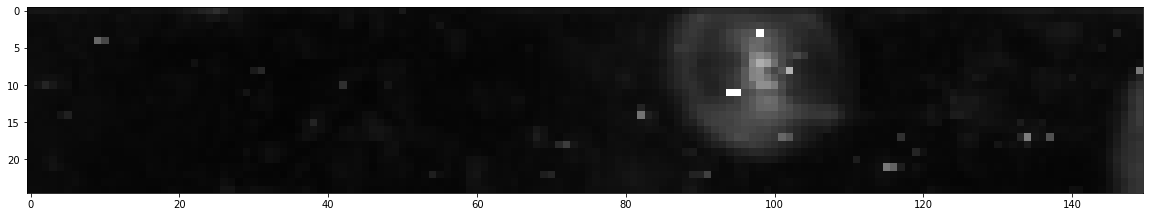

In [6]:
################# predict on original image ###############################
kwargs = {'n_clusters': 3,
          'n_components': 20,
          'min_weight': 0.05}
rvc = ReferenceVectorClassifierPCA(**kwargs)
rvc.fit(X)

RCA_vector = rvc.predict(X)

print("fit score: ", 1 / rvc.error.mean())

RCA_vector = np.clip(RCA_vector, a_min=0, a_max=1)
plt.figure(figsize = (20,4))
plt.imshow(np.swapaxes(RCA_vector.reshape((*shape_X[:2], kwargs['n_clusters'])),0,1)[:,:,:3])
plt.show()
plt.figure(figsize = (20,4))
plt.imshow(rvc.error.reshape(shape_X[:2]).T, cmap='gray', vmin=0, vmax=40)
plt.show()

fit score:  0.0973235367367666


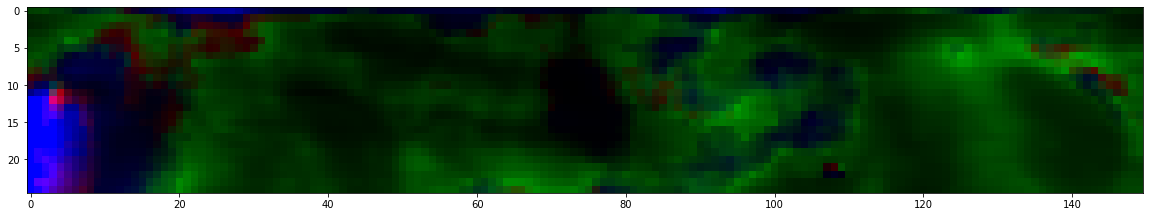

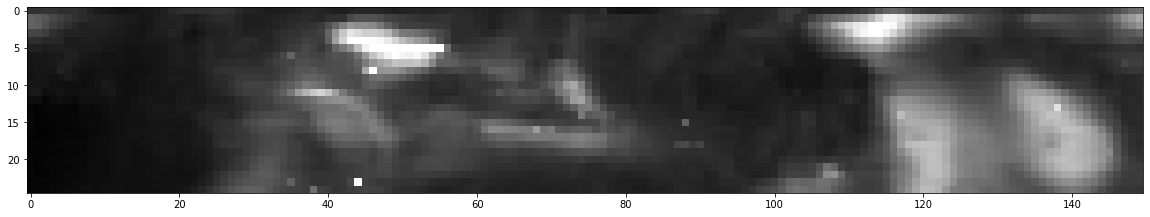

In [7]:
################# predict on new image ###############################
RCA_vector = rvc.predict(Y)

print("fit score: ", 1 / rvc.error.mean())

plt.figure(figsize = (20,4))
RCA_vector = np.clip(RCA_vector, a_min=0, a_max=1)
plt.imshow(np.swapaxes(RCA_vector.reshape((*shape_Y[:2], kwargs['n_clusters'])),0,1)[:,:,:3])
plt.figure(figsize = (20,4))
plt.imshow(rvc.error.reshape(shape_X[:2]).T, cmap='gray', vmin=0, vmax=40)
plt.show()

fit score:  0.22649395748199824


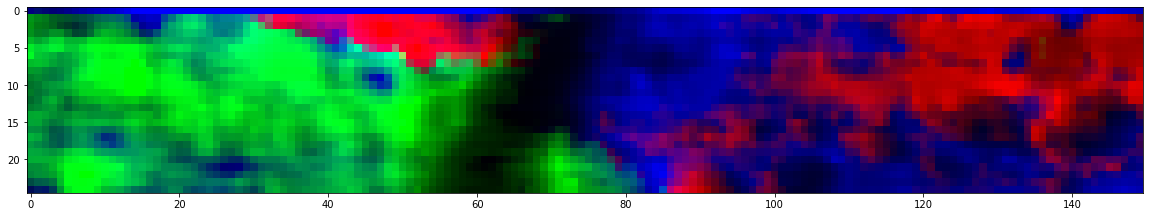

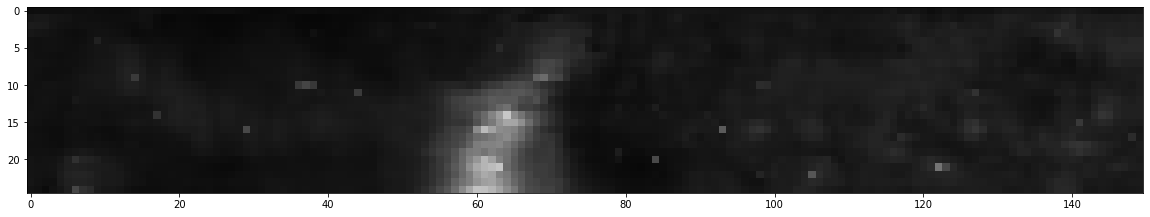

In [8]:
################# predict on new image ###############################
RCA_vector = rvc.predict(Z)

print("fit score: ", 1 / rvc.error.mean())

plt.figure(figsize = (20,4))
RCA_vector = np.clip(RCA_vector, a_min=0, a_max=1)
plt.imshow(np.swapaxes(RCA_vector.reshape((*shape_Z[:2], kwargs['n_clusters'])),0,1)[:,:,:3])
plt.figure(figsize = (20,4))
plt.imshow(rvc.error.reshape(shape_X[:2]).T, cmap='gray', vmin=0, vmax=40)
plt.show()

In [9]:
# ################################# GridSearchCV #######################
# kwargs = {'n_clusters': 3,
#           'n_components': 20,
#           'min_weight': 0.1}

# rvc = ReferenceVectorClassifierPCA(**kwargs)
# clf = model_selection.GridSearchCV(rvc, {'n_clusters': range(3,10)}, scoring=None)
# clf.fit(X)
# print("best estimator: ", clf.best_estimator_)
# print("best score: ", clf.best_score_)